# Using an RL agent to cluster a given set of particles (BYOJ)

In [23]:
366/3+365/6

182.83333333333334

In [21]:
150/24

6.25

In [20]:
49982/3600

13.883888888888889

Johann Brehmer 2020

## Preparations

In [1]:
import sys
import numpy as np
import logging
import torch

sys.path.append("../")
from ginkgo_rl import GinkgoRLInterface, PolicyMCTSAgent

Let's read INFO-level output from the RL agent, but silence a few other libraries that like to produce lots of logging output. To check what's happening in more detail, use `logging.DEBUG` instead.

In [2]:
logger = logging.getLogger("We")
logging.basicConfig(format="%(asctime)s %(levelname).1s: %(message)s", datefmt="%y-%m-%d %H:%M")

silence_list = ["matplotlib", "ginkgo", "ClusterTrellis"]
for key in logging.Logger.manager.loggerDict:
    logging.getLogger(key).setLevel(logging.INFO)
    for check_key in silence_list:
        if check_key in key:
            logging.getLogger(key).setLevel(logging.ERROR)
            break
            

## Set up GinkgoRLInterface instance

First, let's specify the setup for the environment and the agent. Note that these have to matched the setup in which the agent was trained.

I'm working on documentation...

In [3]:
settings = {
    "n_max": 40,
    "n_min": 4,
    "w_jet": False,
    "w_rate": 3.0,
    "qcd_rate": 1.5,
    "pt_min": 1.1**2,
    "qcd_mass": 30.0,
    "w_mass": 80.0,
    "jet_momentum": 400.0,
    "jetdir": (1, 1, 1),
    "beamsize": 20,
    "n_mc_target": 2,
    "n_mc_max": 50,
    "device": torch.device("cpu"),
}

Path to the state dictionary of the RL agent.

In [4]:
# state_dict_filename = "./data/runs/mcts_nn_m_20200930_092039_1010/model.pty"
state_dict_filename = "./data/runs/mcts_nn_xs_20210324_154917_1003/model.pty"

In [5]:
torch

<module 'torch' from '/Users/sebastianmacaluso/anaconda3/lib/python3.7/site-packages/torch/__init__.py'>

In [6]:
torch.load(state_dict_filename)

OrderedDict([('actor.latent_net.0.weight',
              tensor([[-0.0773, -0.0353,  0.0150,  ..., -0.0535,  0.0250,  0.0297],
                      [ 0.0606,  0.0317,  0.0693,  ..., -0.0630, -0.0599,  0.0054],
                      [ 0.0266,  0.0457, -0.0330,  ...,  0.0749, -0.0161, -0.0620],
                      ...,
                      [-0.0609, -0.0652, -0.0117,  ..., -0.0288, -0.0721,  0.0424],
                      [-0.0339, -0.0633,  0.0649,  ..., -0.0611,  0.0072,  0.0507],
                      [ 0.0079,  0.0251,  0.0506,  ...,  0.0232,  0.0685, -0.0386]])),
             ('actor.latent_net.0.bias',
              tensor([ 0.0012, -0.0326, -0.0127,  0.0258, -0.0139,  0.0442,  0.0569, -0.0441,
                       0.0384,  0.0185,  0.0048, -0.0620,  0.0468,  0.0061,  0.0323,  0.0628,
                      -0.0348, -0.0601, -0.0473,  0.0348, -0.0514, -0.0099, -0.0504,  0.0282,
                      -0.0150, -0.0101,  0.0395, -0.0543, -0.0660, -0.0538,  0.0201,  0.0733,
      

And finally...

In [7]:
grl = GinkgoRLInterface(state_dict_filename, **settings)

## If you don't have a jet, make one

The whole point of this interface is applying the RL agent to any tree of your choice. However, for convenience (and cross-checks), the `GinkgoRLInterface` class also provides a `generate` function that allows you to generate Ginkgo jets with the settings used.

In [8]:
jets = grl.generate(n=3)

 N const =  18
 N const =  20
 N const =  23
 N const =  18
 N const =  21
 N const =  20


In [10]:
len(jets)

3

## Run clustering

`GinkgoRLInterface.cluster` is the main function to let the MCTS agent cluster the jets in a jet dictionary. These can be provided as a `dict` object (like we do here) or through the path of a pickled file.

The function returns:
- the clustered jets (as a list of dict objects in the usual Ginkgo style)
- the overall log likelihoods of all reclustered jets
- the number of illegal actions that the RL algorithm picked (hopefully just zeros)
- the computational cost for each jet, measured as the number of evaluations of the splitting likelihood function

If the keyword `filename` is used, the reclustered jets are also pickled to a file.

In [9]:
clustered_jets, log_likelihoods, illegal_actions, costs = grl.cluster(jets, filename="reclustered_jets.pickle")

100%|██████████| 3/3 [07:50<00:00, 156.90s/it]


In [12]:
 log_likelihoods, illegal_actions, costs

([-100.49293088912964, -89.16798186302185, -97.30661630630493],
 [0, 0, 0],
 [344247, 236349, 362693])

## Visualize results

Let's visualize the true and clustered tree using Sebastian's code (make sure that the Ginkgo folder is in the PYTHONPATH).

In [8]:
from scripts import Tree1D_invM as Tree1D

def visualize(jet_top, jet_bottom, label_top="Truth", label_bottom="MCTS"):
    jet_top["node_id"] = jet_top["root_id"]
    jet_bottom["node_id"] = jet_bottom["root_id"]
    
    tree1, tree2 = Tree1D.visualizeTreePair(
        jet_top,
        jet_bottom,
        truthOrder=True, 
        label=True,
        figFormat="jpg",
    )
    tree1.attr(
        rankdir='TB',
        size="10",
        margin='0',
        ratio="0.5",
        nodesep="0.01",
        label=label_top,
        labelloc='t',
        fontsize="36"
    )
    tree2.attr(
        rankdir='BT',
        size="10",
        margin='0',
        ratio="0.5",
        nodesep="0.01",
        label=label_bottom,
        labelloc='b',
        fontsize="36"
    )

    display(tree1)
    display(tree2)


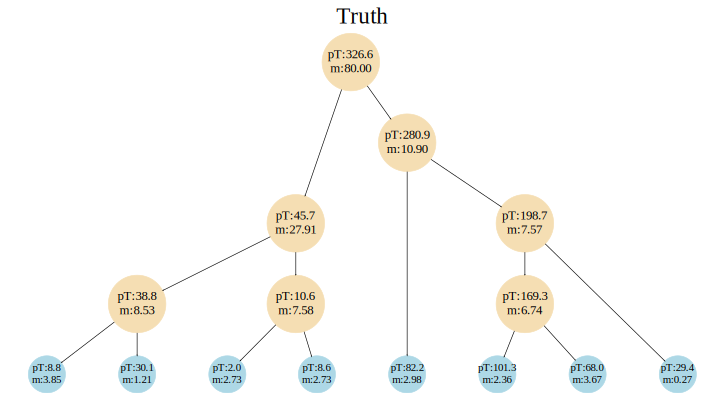

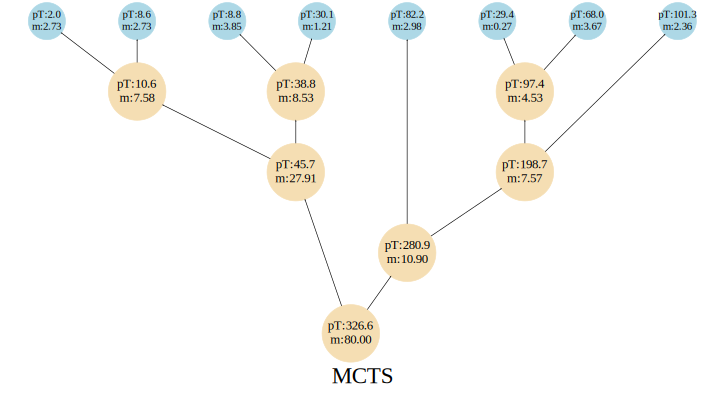

In [11]:
visualize(jets[1], clustered_jets[1])

For comparison, here are `tree` and `content` fields from both jet dicts:

In [26]:
def list_tree(jet, sort_by_energy=False):
    data = list(enumerate(zip(jet["tree"], jet["content"])))
    if sort_by_energy:
        data = sorted(data, reverse=True, key=lambda x : x[1][1][0])
        
    for i, (children, momentum) in data:
        logger.info(f"i = {i:>2d}: children = {children}, p = {momentum}")

In [27]:
list_tree(jets[1], sort_by_energy=True)

20-12-15 13:59 I: i =  0: children = [1 8], p = [407.92156109 230.94010768 230.94010768 230.94010768]
20-12-15 13:59 I: i =  8: children = [ 9 10], p = [349.57042955 199.3479812  197.89296817 207.79645725]
20-12-15 13:59 I: i = 10: children = [11 14], p = [246.45275334 141.46064359 139.48827859 145.64886977]
20-12-15 13:59 I: i = 11: children = [12 13], p = [210.39610406 120.76886713 118.59412674 124.78522421]
20-12-15 13:59 I: i = 12: children = [-1 -1], p = [126.34989637  72.02452326  71.20163054  75.50831308]
20-12-15 13:59 I: i =  9: children = [-1 -1], p = [103.1176915   57.88734634  58.40469824  62.14759657]
20-12-15 13:59 I: i = 13: children = [-1 -1], p = [84.04620769 48.74434386 47.39249619 49.27691112]
20-12-15 13:59 I: i =  1: children = [2 5], p = [58.35113154 31.59212647 33.04713951 23.14365043]
20-12-15 13:59 I: i =  2: children = [3 4], p = [41.82823887 31.69867118 22.42536816 13.00670542]
20-12-15 13:59 I: i = 14: children = [-1 -1], p = [36.05664928 20.69177646 20.8941

In [28]:
list_tree(clustered_jets[1], sort_by_energy=True)

20-12-15 13:59 I: i = 14: children = [13 10], p = [407.92157889 230.94011747 230.94011779 230.94011787]
20-12-15 13:59 I: i = 10: children = [4 9], p = [349.57044484 199.34798992 197.89297682 207.79646634]
20-12-15 13:59 I: i =  9: children = [8 5], p = [246.45275334 141.46064359 139.48827859 145.64886977]
20-12-15 13:59 I: i =  5: children = [-1 -1], p = [126.34989637  72.02452326  71.20163054  75.50831308]
20-12-15 13:59 I: i =  8: children = [7 6], p = [120.10285697  69.43612032  68.28664804  70.14055668]
20-12-15 13:59 I: i =  4: children = [-1 -1], p = [103.1176915   57.88734634  58.40469824  62.14759657]
20-12-15 13:59 I: i =  6: children = [-1 -1], p = [84.04620769 48.74434386 47.39249619 49.27691112]
20-12-15 13:59 I: i = 13: children = [12 11], p = [58.35113405 31.59212755 33.04714097 23.14365154]
20-12-15 13:59 I: i = 11: children = [0 1], p = [41.82823887 31.69867118 22.42536816 13.00670542]
20-12-15 13:59 I: i =  7: children = [-1 -1], p = [36.05664928 20.69177646 20.894151

Finally, let's compare log likelihood numbers:

In [29]:
for i, (jet, log_likelihood) in enumerate(zip(jets, log_likelihoods)):
    logger.info(f"Jet {i}: simulator log likelihood {sum(jet['logLH']):>5.1f} vs MCTS log likelihood {log_likelihood:>5.1f}")
    

20-12-15 14:00 I: Jet 0: simulator log likelihood -112.9 vs MCTS log likelihood -107.6
20-12-15 14:00 I: Jet 1: simulator log likelihood -58.2 vs MCTS log likelihood -56.6
20-12-15 14:00 I: Jet 2: simulator log likelihood -112.6 vs MCTS log likelihood -109.7
